In [57]:
from importlib import reload
import feature_extraction
import data_utils
reload(feature_extraction)
reload(data_utils)
import mat73
import argparse
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, pearsonr, spearmanr
from biosppy.signals import eeg
from biosppy import plotting

from biomarkers import BioMarkers, EEG, EMG, EOG
from feature_extraction import concatenate_features, get_frequency_idx
from data_utils import load_data_from_dir, get_features_in_all_blocks

In [3]:
DIR_NAME = "../1004_CleanData"

all_data = load_data_from_dir(DIR_NAME)

Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_hvha block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded meditation block
Complete loading 10 markers
Loaded breath_hvla block


Start computing spectral power for Block name audio_hvla
Start extracting spectral power...
eeg_band_fft {'Delta': 1283.8625470489715, 'Theta': 757.3916671752921, 'Alpha': 1079.3452684647566, 'Beta1': 784.8363718912454, 'Beta2': 494.94302517162345, 'Gamma': 279.0397183732105}


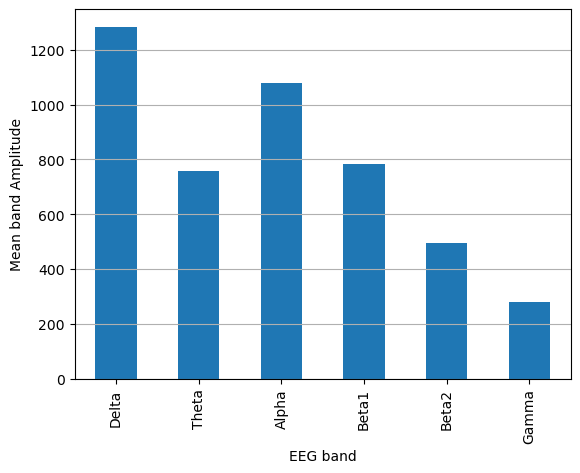

In [5]:
# i = 0
# sampling_rate = 512
# nch = 128
# for block_name, markers in all_data.items():
#     print(f'Start computing spectral power for Block name {block_name}')    
#     marker_to_data = markers.get_all_data()
#     signal = marker_to_data[EEG.__name__][:,:,1]
#     signal = np.reshape(signal, (-1, signal.shape[0]))
#     print(signal.shape)
#     # process it and plot
#     out = eeg.get_power_features(signal=signal, sampling_rate=512.)
#     ts_feat = out["ts"]
#     theta = out["theta"]
#     alpha_low = out["alpha_low"]
#     alpha_high = out["alpha_high"]
#     beta = out["beta"]
#     gamma = out["gamma"]
#     eeg_band_fft = dict()
#     print(out["theta"].shape)
#     eeg_band_fft['theta'] = np.mean(out["theta"][0])
#     eeg_band_fft['alpha_low'] = np.mean(out["alpha_low"][0])
#     eeg_band_fft['alpha_high'] = np.mean(out["alpha_high"][0])
#     eeg_band_fft['beta'] = np.mean(out["beta"][0])  
#     eeg_band_fft['gamma'] = np.mean(out["gamma"][0])  
#     plot_eeg_band(eeg_band_fft)
#    break


In [58]:
all_features = get_features_in_all_blocks(all_blocks=all_data)

print(f"All feature shape {all_features.shape}")

BP feature shape (13, 11)
ECG feature shape (13, 11)
EEG feature shape (13, 1408)
EGG feature shape (13, 11)
EMG feature shape (13, 22)
EOG feature shape (13, 22)
GSR feature shape (13, 11)
Resp feature shape (13, 11)
TREV feature shape (13, 11)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
EEG spetral features shape (13, 768)
audio_hvla block has features: (13, 2286)...
BP feature shape (13, 11)
ECG feature shape (13, 11)
EEG feature shape (13, 1408)
EGG feature shape (13, 11)
EMG feature shape (13, 22)
EOG feature shape (13, 22)
GSR feature shape (13, 11)
Resp feature shape (13, 11)
TREV feature shape (13, 11)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
get shape (768,)
g

In [34]:
# Train machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate

In [73]:
def normalize_label(all_labels, low, high):
    y_transformed = []
    c0, c1, c2 = 0, 0, 0
    for label in all_labels:
        if label < low:
            y_transformed.append(0)
            c0+=1
        elif label >= low and label < high: 
            y_transformed.append(1)
            c1+=1
        else:
            y_transformed.append(2)
            c2+=1

    print(f'0 label: {c0}, 1 label: {c1}, 2 label {c2}')
    return y_transformed

In [103]:
# behavior 
all_labels = np.array([])
label_name = 'arousal'
for block, markers in all_data.items():
    y = markers.get_labels(label_name)
    print(f'{block} block {label_name} labels {y}')
    all_labels = np.concatenate((all_labels, y), axis=None)

print(all_labels.shape)

audio_hvla block arousal labels [0.1175  0.10125 0.30625 0.1575  0.105   0.56125 0.10125 0.1925  0.25125
 0.21125 0.02875 0.56125 0.1925 ]
breath_hvha block arousal labels [0.75875 0.67    0.66    0.56125 0.62625 0.1875  0.6375  0.59625 0.5825
 0.67875 0.2925  0.4325  0.79375]
breath_nvha block arousal labels [0.52375   0.5375    0.62375   0.66      0.55375   0.645     0.54375
 0.5437499 0.44375   0.5875    0.3375    0.605     0.34125  ]
audio_nvla block arousal labels [0.15375 0.19875 0.34375 0.26    0.2325  0.4     0.31625 0.19    0.31
 0.40625 0.28625 0.6625  0.0975 ]
breath_nvla block arousal labels [0.315   0.3225  0.38875 0.28875 0.3025  0.40625 0.3975  0.3525  0.36
 0.2275  0.35875 0.58125 0.11875]
mind wandering block arousal labels [0.5     0.5     0.4475  0.41375 0.42625 0.39375 0.42125 0.53375 0.42375
 0.415   0.3875  0.4225  0.43375]
audio_nvha block arousal labels [0.605   0.43875 0.55125 0.41625 0.375   0.72375 0.765   0.67125 0.36125
 0.42875 0.66625 0.62    0.62875]
aud

In [104]:
#convert y values to categorical values
y_transformed =[]
if label_name == 'valence':
    y_transformed = normalize_label(all_labels, 0.6, 0.8)
elif label_name == 'arousal':
    y_transformed = normalize_label(all_labels, 0.4, 0.7)
else:
    y_transformed = normalize_label(all_labels, 0.82, 0.92)

0 label: 62, 1 label: 57, 2 label 11


In [105]:
groups_list=[[i] for i, j in enumerate(all_labels)]
group_array=np.hstack(groups_list)

print(group_array)
print(all_features.shape, all_labels.shape, group_array.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129]
(130, 1518) (130,) (130,)


In [106]:
clf=LogisticRegression(max_iter=200)
gkf=GroupKFold(n_splits=5)
param_grid = {'classifier__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=16)
gscv.fit(all_features,y_transformed,groups=group_array)

/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=16,
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10, 100]})

In [107]:
best_model = gscv.best_estimator_
print(f'best model: {best_model}')
print(gscv.best_score_)

best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=100, max_iter=200))])
0.7153846153846153


In [89]:
# BP feature shape (13, 11)
# ECG feature shape (13, 11) 22
# EEG feature shape (13, 1408) 1430
# EGG feature shape (13, 11) 1441
# EMG feature shape (13, 22) 1463
# EOG feature shape (13, 22) 1485
# GSR feature shape (13, 11) 1496
# Resp feature shape (13, 11) 1507
# TREV feature shape (13, 11) 1518
# features = (mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
#                           mean_square(data),rms(data),abs_diffs_signal(data),
#                           skewness(data),kurtosis(data))

STATS_NAME = ['mean', 'std', 'ptp', 'var', 'minim', 'maxim', 'mean_square', 'rms', 'abs_diffs_signal', 'skewness', 'kurtosis']
def get_stats_name(i) -> str:
    pos = i%11
    return STATS_NAME[pos]

def get_feature_names(features):
    index=[]
    for i, j in enumerate(features):
        stat_name = get_stats_name(i)
        if i < 11:
            name = 'BP'
        elif i < 22:
            name = 'ECG'
        elif i < 1430:
            channel = int((i-22)/11)+1
            name = f'EEG {channel}'
        elif i < 1441:
            name = 'EGG'
        elif i < 1463:
            channel = int((i-1441)/11)+1
            name = f'EMG {channel}'   
        elif i < 1485:
            channel = int((i-1463)/11)+1
            name = f'EOG {channel}'
        elif i < 1496:
            name = 'GSR'
        elif i < 1507:
            name = 'Resp'
        else:
            name = 'TREV'
        
        index.append(f'{name} {stat_name}')
    return index

<AxesSubplot:title={'center':'arousal Feature Importance'}>

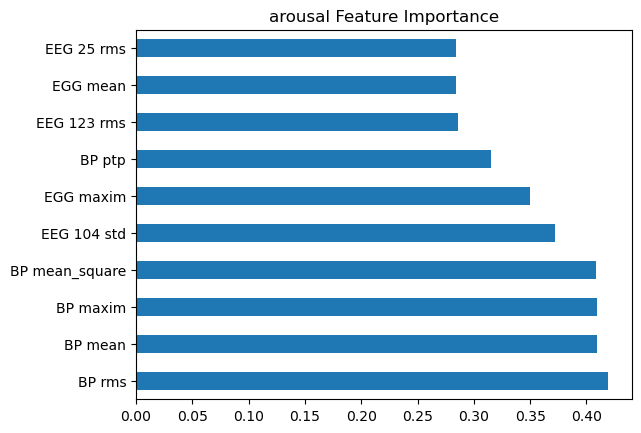

/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [108]:
# assume bigger coefficents has more contribution to the model
# but have to be sure that the features has THE SAME SCALE otherwise this assumption is not correct. 
importance = best_model['classifier'].coef_[0] 
    
feat_importances = pd.Series(importance, index=get_feature_names(importance))
feat_importances.nlargest(10).plot(kind='barh',title = f'{label_name} Feature Importance')

<AxesSubplot:title={'center':'Feature Importance'}>

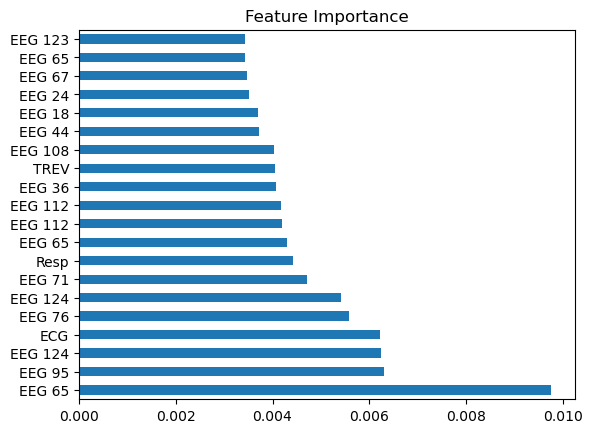

In [49]:
# using Randoom forest (not suitable as the data is too small and the model will overfit easily)
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib

# clf = RandomForestClassifier()
# clf = clf.fit(all_features,y_transformed)
# clf.feature_importances_  
# feat_importances = pd.Series(clf.feature_importances_, index=get_feature_names(clf.feature_importances_))
# feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')